In [ ]:
!ls

sample_data


#External Databases

In [1]:
! pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-4qx67933
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-4qx67933
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 8.1 MB/s 
     |████████████████████████████████| 6.5 MB 37.8 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3958421 sha256=39422c2a24798545d033bfd70766b39e1fb75f3db4f5f39dcb3400c0a8671dc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-26iyckio/wheels/90/a5/44/6bcd83827c8a60628c5ad602f429cd5076bcce5f2a90054947
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [2]:
! pip install ray[tune]

     |████████████████████████████████| 52.7 MB 106 kB/s 
     |████████████████████████████████| 4.1 MB 19.4 MB/s 
     |████████████████████████████████| 226 kB 39.2 MB/s 
     |████████████████████████████████| 125 kB 35.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [3]:
!pip install datasets

     |████████████████████████████████| 325 kB 8.1 MB/s 
     |████████████████████████████████| 212 kB 47.3 MB/s 
     |████████████████████████████████| 136 kB 45.7 MB/s 
     |████████████████████████████████| 1.1 MB 32.9 MB/s 
     |████████████████████████████████| 127 kB 37.1 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 41.4 MB/s 
     |████████████████████████████████| 144 kB 35.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.3 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=042a0660ea13a8668e51ce5e7d9df584ff2014d4f4587b93ee29ac552b0340d4
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


#Libraries

In [5]:
from google.colab import files

import os
import re
import json
import string

import torch
import torch.nn as nn

import numpy as np
#import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers

from datasets import load_metric
from sklearn.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs

import tensorflow_hub as hub
from keras import backend as K

import transformers
print(transformers.__version__)
from transformers import TrainingArguments
from transformers import Trainer
from transformers.trainer_utils import EvalLoopOutput

from transformers import AutoTokenizer, AutoModel
BertTokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
BertEmbModel = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

4.18.0.dev0


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Loading Dataset

In [6]:
class NCBIDataset(torch.utils.data.Dataset):
  def __init__(self, raw_dataset, max_length=180):
    self.raw_x = [x['tokens'] for x in raw_dataset]
    self.raw_y = [x['ner_tags'] for x in raw_dataset]
    
    self.max_length = max_length

  def tokenize_and_preserve_labels(self, sentence, text_labels):
    """
    The tokenizer can split single words into multiple tokens - this breaks
    the labels, so we need to keep track of this!
    """
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = BertTokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

  def __getitem__(self, idx):
    tokens = self.raw_x[idx]
    labels = np.zeros((len(tokens)))
    for i, label in enumerate(self.raw_y[idx]):
      if label == 2:
        labels[i] = 1
      else:
        labels[i] = label

    # This could be moved to __init__ to save time?
    tokens, labels = self.tokenize_and_preserve_labels(tokens, labels)

    # Convert each token to an id number 
    input_ids = BertTokenizer.convert_tokens_to_ids(tokens)
    
    # add and adjust for special tokens
    input_ids = [BertTokenizer.cls_token_id] + input_ids + [BertTokenizer.sep_token_id]  
    labels = [0] + labels + [0]

    # Pad inputs
    input_ids = torch.tensor(np.pad(input_ids, [0, self.max_length-len(input_ids)]))
    labels = torch.tensor(np.pad(labels, [0, self.max_length-len(labels)], constant_values=-100))

    attention_mask = torch.tensor([int(i != 0) for i in input_ids])

    #return {input_ids, labels}
    #return {'input_ids': [input_ids], 'labels': labels}
    return {'input_ids': [input_ids], 'attention_mask': [attention_mask], 'labels': labels}

  def __len__(self):
    return len(self.raw_y)

In [7]:
# Entity mapping, uses BIO tags
def Entity2ID(Sc_Entity):
  return {
        'B': 1,
        'I': 1,
        'O': 0,
    }[Sc_Entity]

def ID2Entity(Sc_Entity):
  return {
        1: 'B',
        #1: 'I',
        0: 'None',
    }[Sc_Entity]


In [8]:
# Download dataset using datasets, might need to install it!
from datasets import load_dataset

raw_train = load_dataset('ncbi_disease', split='train')
raw_test = load_dataset('ncbi_disease', split='test')
raw_val = load_dataset('ncbi_disease', split='validation')

# Convert to torch datasets
train = NCBIDataset(raw_train)
test = NCBIDataset(raw_test)
val = NCBIDataset(raw_val)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/5433 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/924 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

Dataset ncbi_disease downloaded and prepared to /root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03. Subsequent calls will reuse this data.


Reusing dataset ncbi_disease (/root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)
Reusing dataset ncbi_disease (/root/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)


In [9]:
len(train), len(test), len(val)

(5433, 941, 924)

In [10]:
train[2739]

{'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'input_ids': [tensor([  102,   407,   453,  3768,   198,   158,   546,  1211,   259,  1168,
           4662,   115, 30132,  7411,   165,  3111,   214,   106,  2317,   579,
           2971,  2147,  6110,  7459,   198,  4080, 24241,  5354,   131, 10906,
            370,   781,  2980, 13718,   422,  2429,   121,  3014,   131,   106,
          12462, 11458, 13

In [14]:
val[73]

{'attention_mask': [tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'input_ids': [tensor([ 102, 2074, 7342,  137, 4406,  131, 1168, 6625, 5722, 6224,  214,  106,
          2576, 8047, 1017, 1168, 6183,  566,  489,  114,  579,  735, 1199,  205,
           103,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,   

In [11]:
local_hp_train = []
local_hp_val = []
for x in range(500):
  local_hp_train.append(train[x])

for x in range(180):
  local_hp_val.append(val[x])

print(len(local_hp_train))
print(local_hp_train[1])

500
{'input_ids': [tensor([  102,   111, 24243,   861,   153,  7503,  1070,  5703,   145, 16036,
          546,  7421,   579, 14957,   787,  3151,   111, 12157, 10636,  3430,
          214,  8437,   106,  1127,   190, 18260, 12242,  4655,   239, 12186,
          145, 20362,   579,   239, 12186,   546,   422, 10361, 30111,  1352,
         6030,   107,   137,  6130, 14025,   205,   103,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

# Pytorch Model Definition

In [ ]:
class NerModel(nn.Module):
  def __init__(self, b_embeddings, emb_dims=768, ff_dims=14, out_dims=2):
    super(NerModel, self).__init__()
    self.sci_embeddings = b_embeddings
    self.embd_dropout = nn.Dropout(0.1)
    self.ff_dropout = nn.Dropout(0.1)
    self.ff = nn.Linear(emb_dims, ff_dims)
    self.tanh = nn.Tanh()
    self.lstm = nn.LSTM(768, 100, 1, bidirectional=True)
    self.lstm_drop = nn.Dropout(0.4)
    self.ff = nn.Linear(200, 14)
    self.ff_act = nn.ReLU()
    self.classifier = nn.Linear(ff_dims, out_dims)
  def forward(self, **inputs):
    embds = self.sci_embeddings(**inputs)['last_hidden_state']
    out = self.embd_dropout(embds)
    out, _ = self.lstm(out)
    out = self.tanh(out)
    out = self.lstm_drop(out)
    out = self.ff(out)
    out = self.ff_act(out)
    out = self.ff_dropout(out)
    out = self.classifier(out)
    return out


# Metrics and Configs

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    #print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

import math

def load_param():
  for n, v in best_run.hyperparameters.items():
    if n == 'seed':
      setattr(trainer.args, n, math.ceil(v))
      print(n, math.ceil(v))
    else:
      setattr(trainer.args, n, v)
      print(n, v)   

In [ ]:
batch_size = 4
training_args = TrainingArguments(
    "trained_scibert_ner_model", # output dir
    learning_rate=1e-5, 
    num_train_epochs=10, 
    dataloader_drop_last=True,
    per_device_eval_batch_size=batch_size, 
    per_device_train_batch_size=batch_size,
    save_steps=len(train) // batch_size,
    lr_scheduler_type='cosine',
    evaluation_strategy='steps',
    eval_steps=len(train) // batch_size
    )
#print(training_args)

In [ ]:
def collator(batch):
  out =  {
      'input_ids': torch.stack([(x['input_ids'][0]) for x in batch]),
      'attention_mask': torch.stack([x['attention_mask'][0] for x in batch]),
      'labels': torch.stack([x['labels'].clone().detach() for x in batch])
  }
  return out

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight, gamma, reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, ignore_index=-100, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [ ]:
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_labels=2):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs

        weights = torch.tensor([0.38, 1.65]).cuda()  # The no-class label has too many examples, we need to weight the loss - this probably needs further tuning 
        gamma=5
        loss_fct = FocalLoss(weight=weights, gamma=gamma)
        loss = loss_fct(logits.view(-1, num_labels), labels.long().view(-1))
        return (loss, outputs) if return_outputs else loss

    def evaluation_loop(self, dataloader, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval", num_labels=4):
      args = self.args
      prediction_loss_only = prediction_loss_only if prediction_loss_only is not None else args.prediction_loss_only

      self.model.eval()

      all_losses = []
      all_preds = []
      all_labels = []
      for step, sample in enumerate(dataloader):
        for i in range(0, len(sample['labels'])):
          inputs = {}
          inputs['input_ids'] = torch.stack([sample['input_ids'][i].cuda()])
          inputs['attention_mask'] = torch.stack([sample['attention_mask'][i].cuda()])
          inputs['labels'] = torch.stack([sample['labels'][i].cuda()])
          labels = inputs['labels'][0].cpu().numpy()
          
          (loss, logits) = self.compute_loss(self.model, inputs, return_outputs=True)
          logits = logits[0].cpu().detach().numpy()
          preds = np.argmax(nn.Softmax(dim=-1)(torch.tensor(logits)).numpy(), axis=-1)

          all_losses = np.concatenate((all_losses, [loss.detach().cpu().numpy()]), axis=0)

          preds = preds[labels != -100]
          labels = labels[labels != -100]
          all_preds = np.concatenate((all_preds, preds))
          all_labels = np.concatenate((all_labels, labels))

      metrics = {}
      metrics['macro_f1'] = f1_score(all_labels, all_preds, average='macro')
      metrics['macro_precision'] = precision_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['macro_recall'] = recall_score(all_labels, all_preds, average='macro', zero_division=0)
      metrics['micro_f1'] = f1_score(all_labels, all_preds, average='micro')
      metrics['micro_precision'] = precision_score(all_labels, all_preds, average='micro', zero_division=0)
      metrics['micro_recall'] = recall_score(all_labels, all_preds, average='micro', zero_division=0)

      metrics['macro_f1_no_o'] = f1_score(all_labels, all_preds, average='macro', labels=[1])
      metrics['macro_precision_no_o'] = precision_score(all_labels, all_preds, average='macro', labels=[1], zero_division=0)
      metrics['macro_recall_no_o'] = recall_score(all_labels, all_preds, average='macro', labels=[1], zero_division=0)
      metrics['micro_f1_no_o'] = f1_score(all_labels, all_preds, average='micro', labels=[1])
      metrics['micro_precision_no_o'] = precision_score(all_labels, all_preds, average='micro', labels=[1], zero_division=0)
      metrics['micro_recall_no_o'] = recall_score(all_labels, all_preds, average='micro', labels=[1], zero_division=0)

      for key in list(metrics.keys()):
        if not key.startswith(metric_key_prefix):
          metrics[metric_key_prefix + '_' + key] = metrics.pop(key)
      
      metrics[metric_key_prefix + '_loss'] = all_losses.mean().item()

      return EvalLoopOutput(predictions=all_preds, label_ids=all_labels, metrics=metrics, num_samples=len(dataloader))

In [ ]:
def my_hp_space_ray(trial):
    from ray import tune

    return {
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "num_train_epochs": tune.choice(range(8, 20)),
        "weight_decay": tune.uniform(0.0, 0.5),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),  #<16 definetly not working
    }

# Hyperparameter Tuning

In [ ]:
def model_init():
    x = NerModel(BertEmbModel)
    x.sci_embeddings.requires_grad = False
    return x

trainer = MultilabelTrainer(model_init=model_init,
                            args=training_args,
                            train_dataset=train,
                            eval_dataset=val,
                            data_collator=collator  # defines how to merge data into batches, using the collator function above
                            )

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler

best_run = trainer.hyperparameter_search(backend="ray", 
                                         resources_per_trial={"gpu": 1, "cpu": 0},
                                         n_trials=16, 
                                         direction="maximize", 
                                         hp_space=my_hp_space_ray,
                                         search_alg=HyperOptSearch(metric='eval_micro_recall_no_o', mode="max"),  #'eval_*f1_micro'
                                         scheduler=ASHAScheduler(metric='eval_micro_recall_no_o', mode="max")
                                         )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_run

BestRun(run_id='e55a3d20', objective=11.383094363560945, hyperparameters={'learning_rate': 1.1497917821120578e-05, 'num_train_epochs': 19, 'weight_decay': 0.3660243351216811, 'per_device_train_batch_size': 4})

# Cossvalidation

In [ ]:
#import tensorflow as tf
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from torch import nn
from transformers import Trainer

#print('GPU detected:', tf.config.list_physical_devices('GPU'))
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
results = np.zeros(5)
resultss = np.zeros(5)
dataset = ConcatDataset([train, test])



In [ ]:
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    local_train = []
    #i = 0
    for idx in train_ids:
      #if i <= 1920:
      local_train.append(dataset[idx])
      #i += 1
    
    local_test = []
    #i = 0
    for idx in test_ids:
      #if i <= 480:
      local_test.append(dataset[idx])
      #i += 1

    training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=1.1497917821120578e-05, 
                                      weight_decay=0.3660243351216811,
                                      num_train_epochs=19, 
                                      dataloader_drop_last=True,
                                      per_device_eval_batch_size=4, 
                                      per_device_train_batch_size=4,
                                      logging_steps=50,
                                      save_steps=len(local_train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      eval_steps=len(local_train) // batch_size
                                      )

    #learning_rate 1.1497917821120578e-05
    #num_train_epochs 19
    #weight_decay 0.3660243351216811
    #per_device_train_batch_size 4

    # Init the neural network
    ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training
    
    trainer = MultilabelTrainer(model=ner_model,
                                args=training_args,
                                train_dataset=local_train,
                                eval_dataset=local_test,
                                data_collator=collator  # defines how to merge data into batches, using the collator function above
                                )

    #Loading Best parameters
    #load_param()

    #Training
    trainer.train()
          
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(ner_model.state_dict(), save_path)

    # Evaluationfor this fold
    #correct, total = 0, 0
    with torch.no_grad():
      result = trainer.evaluate(local_test)
      print(result)

      # Print accuracy
      print('Accuracy for fold ', fold, ': ', result['eval_micro_f1_no_o'], ' -- ', result['eval_micro_f1'])
      print('--------------------------------')
      results[fold] = result['eval_micro_f1_no_o']
      resultss[fold] = result['eval_micro_f1']
      del result
    


FOLD 0
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5099
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 24206


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1274,0.000200,0.000428,0.918685,0.879130,0.972647,0.965172,0.965172,0.965172,0.857203,0.760463,0.982143,0.857203,0.760463,0.982143
2548,0.000100,0.000421,0.939151,0.908817,0.976606,0.974906,0.974906,0.974906,0.892507,0.820222,0.978764,0.892507,0.820222,0.978764
3822,0.000000,0.000540,0.951303,0.928546,0.977662,0.980403,0.980403,0.980403,0.913658,0.860217,0.974180,0.913658,0.860217,0.974180
5096,0.000000,0.001126,0.953800,0.941618,0.966925,0.981918,0.981918,0.981918,0.917757,0.889493,0.947876,0.917757,0.889493,0.947876
6370,0.000000,0.000652,0.948867,0.921113,0.982257,0.979119,0.979119,0.979119,0.909536,0.843898,0.986245,0.909536,0.843898,0.986245
7644,0.000000,0.000436,0.909807,0.864953,0.975273,0.960369,0.960369,0.960369,0.842277,0.730626,0.994208,0.842277,0.730626,0.994208
8918,0.000000,0.000994,0.953778,0.929020,0.982841,0.981302,0.981302,0.981302,0.918110,0.859882,0.984797,0.918110,0.859882,0.984797
10192,0.000000,0.000878,0.954018,0.928863,0.983628,0.981379,0.981379,0.981379,0.918548,0.859365,0.986486,0.918548,0.859365,0.986486
11466,0.000000,0.001047,0.950970,0.924655,0.982258,0.980069,0.980069,0.980069,0.913199,0.851126,0.985039,0.913199,0.851126,0.985039
12740,0.000000,0.001271,0.957918,0.936141,0.982905,0.983125,0.983125,0.983125,0.925349,0.874383,0.982625,0.925349,0.874383,0.982625


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1274
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2548
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-3822
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5096
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6370
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-7644
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8918
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9656007357238616, 'eval_macro_precision': 0.9516634843842251, 'eval_macro_recall': 0.9807490697078223, 'eval_micro_f1': 0.9864899573637438, 'eval_micro_precision': 0.9864899573637438, 'eval_micro_recall': 0.9864899573637438, 'eval_macro_f1_no_o': 0.9387945077961368, 'eval_macro_precision_no_o': 0.9065168539325843, 'eval_macro_recall_no_o': 0.9734555984555985, 'eval_micro_f1_no_o': 0.9387945077961368, 'eval_micro_precision_no_o': 0.9065168539325843, 'eval_micro_recall_no_o': 0.9734555984555985, 'eval_loss': 0.0020676296029555285, 'eval_runtime': 16.7895, 'eval_samples_per_second': 18.94, 'eval_steps_per_second': 4.765, 'epoch': 19.0}
Accuracy for fold  0 :  0.9387945077961368  --  0.9864899573637438
--------------------------------
FOLD 1
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5099
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 24206


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1274,0.000000,0.000251,0.966152,0.942657,0.993181,0.987662,0.987662,0.987662,0.939169,0.885314,1.000000,0.939169,0.885314,1.000000
2548,0.000100,0.000209,0.972368,0.952924,0.994123,0.990040,0.990040,0.990040,0.950270,0.905936,0.999168,0.950270,0.905936,0.999168
3822,0.000000,0.000097,0.968339,0.946328,0.993401,0.988507,0.988507,0.988507,0.943070,0.892716,0.999445,0.943070,0.892716,0.999445
5096,0.000000,0.000406,0.964988,0.940817,0.992933,0.987213,0.987213,0.987213,0.937094,0.881634,1.000000,0.937094,0.881634,1.000000
6370,0.000000,0.000267,0.960918,0.934442,0.992057,0.985627,0.985627,0.985627,0.929843,0.868884,1.000000,0.929843,0.868884,1.000000
7644,0.000000,0.000361,0.973690,0.955277,0.994152,0.990542,0.990542,0.990542,0.952633,0.910701,0.998613,0.952633,0.910701,0.998613
8918,0.000000,0.000293,0.974747,0.958221,0.992897,0.990964,0.990964,0.990964,0.954509,0.916944,0.995284,0.954509,0.916944,0.995284
10192,0.000000,0.000369,0.973594,0.955519,0.993641,0.990515,0.990515,0.990515,0.952457,0.911303,0.997503,0.952457,0.911303,0.997503
11466,0.000000,0.000338,0.978648,0.965146,0.993204,0.992417,0.992417,0.992417,0.961502,0.930909,0.994175,0.961502,0.930909,0.994175
12740,0.000000,0.000287,0.979187,0.965311,0.994174,0.992602,0.992602,0.992602,0.962477,0.931034,0.996117,0.962477,0.931034,0.996117


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1274
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2548
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-3822
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5096
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6370
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-7644
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8918
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9736710333466643, 'eval_macro_precision': 0.955544544843397, 'eval_macro_recall': 0.9937801948875779, 'eval_micro_f1': 0.9905416116248349, 'eval_micro_precision': 0.9905416116248349, 'eval_micro_recall': 0.9905416116248349, 'eval_macro_f1_no_o': 0.9525953389830508, 'eval_macro_precision_no_o': 0.9113250570053205, 'eval_macro_recall_no_o': 0.9977808599167822, 'eval_micro_f1_no_o': 0.9525953389830508, 'eval_micro_precision_no_o': 0.9113250570053205, 'eval_micro_recall_no_o': 0.9977808599167822, 'eval_loss': 0.00017697828472081878, 'eval_runtime': 16.3708, 'eval_samples_per_second': 19.425, 'eval_steps_per_second': 4.887, 'epoch': 19.0}
Accuracy for fold  1 :  0.9525953389830508  --  0.9905416116248349
--------------------------------
FOLD 2
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5099
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 24206


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1274,0.000000,0.000162,0.970758,0.950850,0.993157,0.988918,0.988918,0.988918,0.947714,0.901875,0.998463,0.947714,0.901875,0.998463
2548,0.000000,0.000042,0.987632,0.978700,0.997009,0.995438,0.995438,0.995438,0.977806,0.957515,0.998975,0.977806,0.957515,0.998975
3822,0.000000,0.000045,0.988320,0.979780,0.997266,0.995696,0.995696,0.995696,0.979039,0.959646,0.999231,0.979039,0.959646,0.999231
5096,0.000000,0.000039,0.988252,0.979662,0.997252,0.995670,0.995670,0.995670,0.978916,0.959410,0.999231,0.978916,0.959410,0.999231
6370,0.000000,0.000031,0.986606,0.976943,0.996794,0.995052,0.995052,0.995052,0.975970,0.954000,0.998975,0.975970,0.954000,0.998975
7644,0.000000,0.000033,0.987911,0.978974,0.997294,0.995541,0.995541,0.995541,0.978307,0.958006,0.999488,0.978307,0.958006,0.999488
8918,0.000000,0.000045,0.986333,0.976476,0.996737,0.994949,0.994949,0.994949,0.975482,0.953068,0.998975,0.975482,0.953068,0.998975
10192,0.000000,0.000040,0.988178,0.979741,0.997010,0.995644,0.995644,0.995644,0.978782,0.959626,0.998719,0.978782,0.959626,0.998719
11466,0.000000,0.000026,0.988524,0.980233,0.997195,0.995773,0.995773,0.995773,0.979402,0.960581,0.998975,0.979402,0.960581,0.998975
12740,0.000000,0.000026,0.988926,0.981344,0.996826,0.995928,0.995928,0.995928,0.980121,0.962917,0.997950,0.980121,0.962917,0.997950


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1274
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2548
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-3822
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5096
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6370
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-7644
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8918
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9887960297155707, 'eval_macro_precision': 0.9808064151205234, 'eval_macro_recall': 0.997138709440067, 'eval_micro_f1': 0.9958763949382747, 'eval_micro_precision': 0.9958763949382747, 'eval_micro_recall': 0.9958763949382747, 'eval_macro_f1_no_o': 0.9798893916540974, 'eval_macro_precision_no_o': 0.9617567234147545, 'eval_macro_recall_no_o': 0.9987189341532154, 'eval_micro_f1_no_o': 0.9798893916540974, 'eval_micro_precision_no_o': 0.9617567234147545, 'eval_micro_recall_no_o': 0.9987189341532154, 'eval_loss': 2.420706463107108e-05, 'eval_runtime': 16.3092, 'eval_samples_per_second': 19.498, 'eval_steps_per_second': 4.905, 'epoch': 19.0}
Accuracy for fold  2 :  0.9798893916540974  --  0.9958763949382747
--------------------------------
FOLD 3
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5099
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 24206


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1274,0.000000,0.000052,0.969874,0.950072,0.992203,0.987981,0.987981,0.987981,0.946519,0.900439,0.997570,0.946519,0.900439,0.997570
2548,0.000000,0.000034,0.990686,0.983762,0.997878,0.996399,0.996399,0.996399,0.983391,0.967552,0.999757,0.983391,0.967552,0.999757
3822,0.000000,0.000028,0.992740,0.987314,0.998327,0.997202,0.997202,0.997202,0.987047,0.974657,0.999757,0.987047,0.974657,0.999757
5096,0.000000,0.000023,0.992207,0.986489,0.998104,0.996995,0.996995,0.996995,0.986098,0.973037,0.999514,0.986098,0.973037,0.999514
6370,0.000000,0.000047,0.992805,0.987527,0.998235,0.997228,0.997228,0.997228,0.987163,0.975113,0.999514,0.987163,0.975113,0.999514
7644,0.000000,0.000026,0.993803,0.989267,0.998452,0.997617,0.997617,0.997617,0.988942,0.978592,0.999514,0.988942,0.978592,0.999514
8918,0.000000,0.000034,0.980231,0.966116,0.995544,0.992229,0.992229,0.992229,0.964830,0.932261,0.999757,0.964830,0.932261,0.999757


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1274
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2548
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-3822
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5096
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6370
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-7644
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8918
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1274,0.000000,0.000052,0.969874,0.950072,0.992203,0.987981,0.987981,0.987981,0.946519,0.900439,0.997570,0.946519,0.900439,0.997570
2548,0.000000,0.000034,0.990686,0.983762,0.997878,0.996399,0.996399,0.996399,0.983391,0.967552,0.999757,0.983391,0.967552,0.999757
3822,0.000000,0.000028,0.992740,0.987314,0.998327,0.997202,0.997202,0.997202,0.987047,0.974657,0.999757,0.987047,0.974657,0.999757
5096,0.000000,0.000023,0.992207,0.986489,0.998104,0.996995,0.996995,0.996995,0.986098,0.973037,0.999514,0.986098,0.973037,0.999514
6370,0.000000,0.000047,0.992805,0.987527,0.998235,0.997228,0.997228,0.997228,0.987163,0.975113,0.999514,0.987163,0.975113,0.999514
7644,0.000000,0.000026,0.993803,0.989267,0.998452,0.997617,0.997617,0.997617,0.988942,0.978592,0.999514,0.988942,0.978592,0.999514
8918,0.000000,0.000034,0.980231,0.966116,0.995544,0.992229,0.992229,0.992229,0.964830,0.932261,0.999757,0.964830,0.932261,0.999757
10192,0.000000,0.000022,0.985512,0.974939,0.996733,0.994353,0.994353,0.994353,0.974195,0.949908,0.999757,0.974195,0.949908,0.999757
11466,0.000000,0.000022,0.987922,0.979123,0.997162,0.995311,0.995311,0.995311,0.978475,0.958304,0.999514,0.978475,0.958304,0.999514
12740,0.000000,0.000022,0.988449,0.979925,0.997385,0.995519,0.995519,0.995519,0.979412,0.959879,0.999757,0.979412,0.959879,0.999757


Saving model checkpoint to trained_scibert_ner_model/checkpoint-10192
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-11466
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-12740
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-14014
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-15288
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-16562
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-17836
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpo

Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9894930683107281, 'eval_macro_precision': 0.9820050648606685, 'eval_macro_recall': 0.9972959928266589, 'eval_micro_f1': 0.9959331692785909, 'eval_micro_precision': 0.9959331692785909, 'eval_micro_recall': 0.9959331692785909, 'eval_macro_f1_no_o': 0.9812671518911825, 'eval_macro_precision_no_o': 0.964126611957796, 'eval_macro_recall_no_o': 0.9990281827016521, 'eval_micro_f1_no_o': 0.9812671518911825, 'eval_micro_precision_no_o': 0.964126611957796, 'eval_micro_recall_no_o': 0.9990281827016521, 'eval_loss': 2.1027348815078e-05, 'eval_runtime': 16.0243, 'eval_samples_per_second': 19.845, 'eval_steps_per_second': 4.992, 'epoch': 19.0}
Accuracy for fold  3 :  0.9812671518911825  --  0.9959331692785909
--------------------------------
FOLD 4
--------------------------------


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5100
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 24225


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1275,0.000000,0.000012,0.987071,0.977531,0.997121,0.995226,0.995226,0.995226,0.976802,0.955119,0.999492,0.976802,0.955119,0.999492
2550,0.000000,0.000005,0.992467,0.986862,0.998242,0.997243,0.997243,0.997243,0.986470,0.973782,0.999492,0.986470,0.973782,0.999492
3825,0.000000,0.000004,0.992950,0.987707,0.998341,0.997422,0.997422,0.997422,0.987335,0.975471,0.999492,0.987335,0.975471,0.999492
5100,0.000000,0.000004,0.992330,0.986622,0.998214,0.997192,0.997192,0.997192,0.986222,0.973300,0.999492,0.986222,0.973300,0.999492
6375,0.000000,0.000003,0.992607,0.987000,0.998383,0.997294,0.997294,0.997294,0.986720,0.974029,0.999746,0.986720,0.974029,0.999746
7650,0.000000,0.000003,0.992676,0.987121,0.998397,0.997320,0.997320,0.997320,0.986844,0.974270,0.999746,0.986844,0.974270,0.999746
8925,0.000000,0.000003,0.993090,0.987845,0.998482,0.997473,0.997473,0.997473,0.987586,0.975719,0.999746,0.987586,0.975719,0.999746
10200,0.000000,0.000003,0.990820,0.983888,0.998014,0.996630,0.996630,0.996630,0.983516,0.967805,0.999746,0.983516,0.967805,0.999746
11475,0.000000,0.000003,0.993090,0.987845,0.998482,0.997473,0.997473,0.997473,0.987586,0.975719,0.999746,0.987586,0.975719,0.999746
12750,0.000000,0.000003,0.987955,0.978945,0.997418,0.995558,0.995558,0.995558,0.978385,0.957918,0.999746,0.978385,0.957918,0.999746


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1275
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2550
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-3825
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6375
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-7650
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8925
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished. Saving trained model.
Starting testing
{'eval_macro_f1': 0.9914373260893067, 'eval_macro_precision': 0.9849611301233898, 'eval_macro_recall': 0.9981418310806423, 'eval_micro_f1': 0.9968601623525808, 'eval_micro_precision': 0.9968601623525808, 'eval_micro_recall': 0.9968601623525808, 'eval_macro_f1_no_o': 0.9846230778847357, 'eval_macro_precision_no_o': 0.9699507389162562, 'eval_macro_recall_no_o': 0.9997461284589998, 'eval_micro_f1_no_o': 0.9846230778847357, 'eval_micro_precision_no_o': 0.9699507389162562, 'eval_micro_recall_no_o': 0.9997461284589998, 'eval_loss': 2.779848126853917e-06, 'eval_runtime': 15.7269, 'eval_samples_per_second': 20.22, 'eval_steps_per_second': 5.087, 'epoch': 19.0}
Accuracy for fold  4 :  0.9846230778847357  --  0.9968601623525808
--------------------------------


# Results

In [ ]:
results

array([0.93879451, 0.95259534, 0.97988939, 0.98126715, 0.98462308])

In [ ]:
resultss

array([0.98648996, 0.99054161, 0.99587639, 0.99593317, 0.99686016])

In [ ]:
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
key = 0
for value in results:
  print(f'Fold {key}: {value} %')
  sum += value
  key += 1
print(f'Average: {sum/len(results)} %')

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 0.9387945077961368 %
Fold 1: 0.9525953389830508 %
Fold 2: 0.9798893916540974 %
Fold 3: 0.9812671518911825 %
Fold 4: 0.9846230778847357 %
Average: 0.9674338936418406 %


# Pytorch Training - Loop UPDT

In [ ]:
device = 'cuda'

In [ ]:
training_args = TrainingArguments("trained_scibert_ner_model", # output dir
                                      learning_rate=1.1497917821120578e-05, 
                                      num_train_epochs=19, 
                                      dataloader_drop_last=True,
                                      per_device_eval_batch_size=4, 
                                      per_device_train_batch_size=4,
                                      logging_steps=50,
                                      save_steps=len(train) // batch_size,
                                      lr_scheduler_type='cosine',
                                      evaluation_strategy='steps',
                                      weight_decay=0.3660243351216811,
                                      eval_steps=len(train) // batch_size,
                                      report_to='all'
                                      )

#learning_rate 1.1497917821120578e-05
#num_train_epochs 19
#weight_decay 0.3660243351216811
#per_device_train_batch_size 4

#load_param()

In [ ]:
loop_val = 10
loop_results = np.zeros(loop_val)
loop_resultss = np.zeros(loop_val)
for r in range(loop_val):

  ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training

  trainer = MultilabelTrainer(
      model=ner_model, 
      args=training_args, 
      train_dataset=train, 
      eval_dataset=test,
      data_collator=collator  # defines how to merge data into batches, using the collator function above
  )

  # Print
  print(f'Train run #{r}')
  print('--------------------------------')

  trainer.train()

  # Process is complete.
  print('Training process has finished.')

  # Print about testing
  print('Starting testing')

  with torch.no_grad():
    result = trainer.evaluate(test)
    print(result)

    # Print accuracy
    print('Accuracy for fold ', r, ': ', result['eval_micro_f1_no_o'], ' -- ', result['eval_micro_f1'])
    print('--------------------------------')
    loop_results[r] = result['eval_micro_f1_no_o']
    loop_resultss[r] = result['eval_micro_f1']
    del result

  if r > 0:
    if loop_results[r] < loop_results[r-1]:
      save_path = f'./model-fold-{r}.pth'
      torch.save(ner_model.state_dict(), save_path)

  print('Testing process has finished.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Train run #0
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000100,0.000231,0.923174,0.883593,0.976410,0.968958,0.968958,0.968958,0.863867,0.768823,0.985724,0.863867,0.768823,0.985724
2716,0.000100,0.000255,0.911743,0.866943,0.976055,0.963422,0.963422,0.963422,0.844207,0.734827,0.991842,0.844207,0.734827,0.991842
4074,0.000000,0.000153,0.937894,0.904510,0.979919,0.975547,0.975547,0.975547,0.889537,0.810682,0.985384,0.889537,0.810682,0.985384
5432,0.000000,0.000156,0.937783,0.904532,0.979598,0.975513,0.975513,0.975513,0.889332,0.810803,0.984704,0.889332,0.810803,0.984704
6790,0.000000,0.000209,0.941372,0.910853,0.978842,0.977143,0.977143,0.977143,0.895578,0.823865,0.980965,0.895578,0.823865,0.980965
8148,0.000000,0.000258,0.952566,0.930717,0.977612,0.982000,0.982000,0.982000,0.915200,0.864571,0.972128,0.915200,0.864571,0.972128
9506,0.000000,0.000152,0.946956,0.917627,0.982523,0.979419,0.979419,0.979419,0.905460,0.836794,0.986404,0.905460,0.836794,0.986404
10864,0.000000,0.000200,0.935472,0.900288,0.980506,0.974426,0.974426,0.974426,0.885336,0.801931,0.988103,0.885336,0.801931,0.988103
12222,0.000000,0.000117,0.937711,0.902705,0.982375,0.975343,0.975343,0.975343,0.889296,0.806416,0.991162,0.889296,0.806416,0.991162
13580,0.000000,0.000193,0.949190,0.919989,0.984525,0.980302,0.980302,0.980302,0.909432,0.841132,0.989803,0.909432,0.841132,0.989803


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


{'eval_macro_f1': 0.9558039744255709, 'eval_macro_precision': 0.9329129458663312, 'eval_macro_recall': 0.9822002710722395, 'eval_micro_f1': 0.9831884254856678, 'eval_micro_precision': 0.9831884254856678, 'eval_micro_recall': 0.9831884254856678, 'eval_macro_f1_no_o': 0.9210148396361895, 'eval_macro_precision_no_o': 0.8679699248120301, 'eval_macro_recall_no_o': 0.9809653297076818, 'eval_micro_f1_no_o': 0.9210148396361895, 'eval_micro_precision_no_o': 0.8679699248120301, 'eval_micro_recall_no_o': 0.9809653297076818, 'eval_loss': 0.00027959382999607606, 'eval_runtime': 16.9163, 'eval_samples_per_second': 13.892, 'eval_steps_per_second': 3.488, 'epoch': 19.0}
Accuracy for fold  0 :  0.9210148396361895  --  0.9831884254856678
--------------------------------
Testing process has finished.
Train run #1
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000535,0.956909,0.945123,0.969546,0.984071,0.984071,0.984071,0.922697,0.895680,0.951394,0.922697,0.895680,0.951394
2716,0.000000,0.000674,0.955438,0.937979,0.974854,0.983290,0.983290,0.983290,0.920208,0.879963,0.964310,0.920208,0.879963,0.964310
4074,0.000000,0.000516,0.956887,0.939372,0.976364,0.983834,0.983834,0.983834,0.922802,0.882444,0.967029,0.922802,0.882444,0.967029
5432,0.000000,0.000278,0.948839,0.922009,0.980748,0.980302,0.980302,0.980302,0.908719,0.846131,0.981305,0.908719,0.846131,0.981305
6790,0.000000,0.000638,0.953885,0.933606,0.976875,0.982577,0.982577,0.982577,0.917511,0.870613,0.969748,0.917511,0.870613,0.969748
8148,0.000000,0.000847,0.960026,0.944497,0.977062,0.985090,0.985090,0.985090,0.928373,0.892689,0.967029,0.928373,0.892689,0.967029
9506,0.000000,0.000381,0.933268,0.896278,0.981432,0.973373,0.973373,0.973373,0.881535,0.793526,0.991502,0.881535,0.793526,0.991502
10864,0.000000,0.000215,0.943068,0.912696,0.980277,0.977822,0.977822,0.977822,0.898587,0.827281,0.983345,0.898587,0.827281,0.983345
12222,0.000000,0.000241,0.941140,0.908135,0.982468,0.976871,0.976871,0.976871,0.895279,0.817467,0.989463,0.895279,0.817467,0.989463
13580,0.000000,0.000241,0.945101,0.914945,0.981938,0.978637,0.978637,0.978637,0.902193,0.831470,0.986064,0.902193,0.831470,0.986064


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.9505461244212561, 'eval_macro_precision': 0.9259071205920382, 'eval_macro_recall': 0.979368602992958, 'eval_micro_f1': 0.9810827333242766, 'eval_micro_precision': 0.9810827333242766, 'eval_micro_recall': 0.9810827333242766, 'eval_macro_f1_no_o': 0.9116854288885364, 'eval_macro_precision_no_o': 0.8543833580980683, 'eval_macro_recall_no_o': 0.9772263766145479, 'eval_micro_f1_no_o': 0.9116854288885364, 'eval_micro_precision_no_o': 0.8543833580980683, 'eval_micro_recall_no_o': 0.9772263766145479, 'eval_loss': 0.0003258758522068709, 'eval_runtime': 17.7347, 'eval_samples_per_second': 13.251, 'eval_steps_per_second': 3.327, 'epoch': 19.0}
Accuracy for fold  1 :  0.9116854288885364  --  0.9810827333242766
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Testing process has finished.
Train run #2
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000908,0.958418,0.949914,0.967355,0.984751,0.984751,0.984751,0.925328,0.905894,0.945615,0.925328,0.905894,0.945615
2716,0.000000,0.000436,0.961583,0.944965,0.979933,0.985634,0.985634,0.985634,0.931186,0.892980,0.972808,0.931186,0.892980,0.972808
4074,0.000000,0.000478,0.940134,0.910275,0.976633,0.976702,0.976702,0.976702,0.893346,0.823209,0.976547,0.893346,0.823209,0.976547
5432,0.000000,0.000276,0.950685,0.923791,0.982655,0.981015,0.981015,0.981015,0.912010,0.849311,0.984704,0.912010,0.849311,0.984704
6790,0.000000,0.000368,0.949178,0.922423,0.980974,0.980437,0.980437,0.980437,0.909320,0.846921,0.981645,0.909320,0.846921,0.981645
8148,0.000000,0.000231,0.953732,0.933247,0.976988,0.982509,0.982509,0.982509,0.917242,0.869857,0.970088,0.917242,0.869857,0.970088
9506,0.000000,0.000317,0.947720,0.920199,0.980635,0.979826,0.979826,0.979826,0.906750,0.842474,0.981645,0.906750,0.842474,0.981645
10864,0.000000,0.000267,0.953413,0.930489,0.979878,0.982271,0.982271,0.982271,0.916746,0.863582,0.976886,0.916746,0.863582,0.976886
12222,0.000000,0.000297,0.950726,0.923542,0.983108,0.981015,0.981015,0.981015,0.912093,0.848698,0.985724,0.912093,0.848698,0.985724
13580,0.000000,0.000492,0.957291,0.935370,0.982389,0.983800,0.983800,0.983800,0.923643,0.872920,0.980625,0.923643,0.872920,0.980625


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


{'eval_macro_f1': 0.9562288947215236, 'eval_macro_precision': 0.9342539177303043, 'eval_macro_recall': 0.9814069545999915, 'eval_micro_f1': 0.9833922021464475, 'eval_micro_precision': 0.9833922021464475, 'eval_micro_recall': 0.9833922021464475, 'eval_macro_f1_no_o': 0.9217474795967355, 'eval_macro_precision_no_o': 0.8708799516177804, 'eval_macro_recall_no_o': 0.9789259007477906, 'eval_micro_f1_no_o': 0.9217474795967355, 'eval_micro_precision_no_o': 0.8708799516177804, 'eval_micro_recall_no_o': 0.9789259007477906, 'eval_loss': 0.0006267097897756206, 'eval_runtime': 16.0087, 'eval_samples_per_second': 14.68, 'eval_steps_per_second': 3.686, 'epoch': 19.0}
Accuracy for fold  2 :  0.9217474795967355  --  0.9833922021464475
--------------------------------
Testing process has finished.
Train run #3
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000432,0.947999,0.922715,0.977745,0.980064,0.980064,0.980064,0.907164,0.848270,0.974847,0.907164,0.848270,0.974847
2716,0.000000,0.000425,0.952812,0.927699,0.982258,0.981932,0.981932,0.981932,0.915743,0.857355,0.982665,0.915743,0.857355,0.982665
4074,0.000000,0.000468,0.956580,0.936988,0.978668,0.983630,0.983630,0.983630,0.922308,0.877069,0.972468,0.922308,0.877069,0.972468
5432,0.000000,0.000608,0.958422,0.941749,0.976855,0.984445,0.984445,0.984445,0.925528,0.887157,0.967369,0.925528,0.887157,0.967369
6790,0.000000,0.000626,0.958821,0.941794,0.977686,0.984581,0.984581,0.984581,0.926251,0.887057,0.969069,0.926251,0.887057,0.969069
8148,0.000000,0.000684,0.958507,0.941887,0.976874,0.984479,0.984479,0.984479,0.925679,0.887434,0.967369,0.925679,0.887434,0.967369
9506,0.000000,0.000400,0.954893,0.934409,0.978140,0.982951,0.982951,0.982951,0.919319,0.871951,0.972128,0.919319,0.871951,0.972128
10864,0.000000,0.000436,0.954420,0.931961,0.980255,0.982679,0.982679,0.982679,0.918530,0.866486,0.977226,0.918530,0.866486,0.977226
12222,0.000000,0.000649,0.957154,0.938852,0.977611,0.983902,0.983902,0.983902,0.923301,0.881099,0.969748,0.923301,0.881099,0.969748
13580,0.000000,0.000692,0.957335,0.939025,0.977799,0.983970,0.983970,0.983970,0.923625,0.881408,0.970088,0.923625,0.881408,0.970088


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


{'eval_macro_f1': 0.9582028964410441, 'eval_macro_precision': 0.9401912131545827, 'eval_macro_recall': 0.9782902882129235, 'eval_micro_f1': 0.9843091971199566, 'eval_micro_precision': 0.9843091971199566, 'eval_micro_recall': 0.9843091971199566, 'eval_macro_f1_no_o': 0.9251700680272108, 'eval_macro_precision_no_o': 0.8836633663366337, 'eval_macro_recall_no_o': 0.9707681849082257, 'eval_micro_f1_no_o': 0.9251700680272108, 'eval_micro_precision_no_o': 0.8836633663366337, 'eval_micro_recall_no_o': 0.9707681849082257, 'eval_loss': 0.0007548030963815601, 'eval_runtime': 17.604, 'eval_samples_per_second': 13.349, 'eval_steps_per_second': 3.352, 'epoch': 19.0}
Accuracy for fold  3 :  0.9251700680272108  --  0.9843091971199566
--------------------------------
Testing process has finished.
Train run #4
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000207,0.945855,0.916371,0.981674,0.978977,0.978977,0.978977,0.903507,0.834437,0.985044,0.903507,0.834437,0.985044
2716,0.000000,0.000303,0.950709,0.926810,0.978519,0.981185,0.981185,0.981185,0.911952,0.856418,0.975187,0.911952,0.856418,0.975187
4074,0.000000,0.000363,0.953872,0.933700,0.976724,0.982577,0.982577,0.982577,0.917484,0.870840,0.969409,0.917484,0.870840,0.969409
5432,0.000000,0.000495,0.953719,0.935555,0.974023,0.982611,0.982611,0.982611,0.917152,0.875232,0.963290,0.917152,0.875232,0.963290
6790,0.000000,0.000553,0.954046,0.936919,0.973060,0.982781,0.982781,0.982781,0.917708,0.878223,0.960911,0.917708,0.878223,0.960911
8148,0.000000,0.000624,0.954765,0.938451,0.972776,0.983087,0.983087,0.983087,0.918972,0.881398,0.959891,0.918972,0.881398,0.959891
9506,0.000000,0.000739,0.954162,0.937589,0.972493,0.982849,0.982849,0.982849,0.917900,0.879713,0.959551,0.917900,0.879713,0.959551
10864,0.000000,0.000747,0.954973,0.940016,0.971341,0.983222,0.983222,0.983222,0.919307,0.884906,0.956492,0.919307,0.884906,0.956492
12222,0.000000,0.000836,0.953586,0.936532,0.972512,0.982611,0.982611,0.982611,0.916883,0.877564,0.959891,0.916883,0.877564,0.959891
13580,0.000000,0.000990,0.955697,0.941583,0.971057,0.983528,0.983528,0.983528,0.920583,0.888152,0.955472,0.920583,0.888152,0.955472


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.9542197462889145, 'eval_macro_precision': 0.9379253210544746, 'eval_macro_recall': 0.9722098882420839, 'eval_micro_f1': 0.9828827604944981, 'eval_micro_precision': 0.9828827604944981, 'eval_micro_recall': 0.9828827604944981, 'eval_macro_f1_no_o': 0.9179954441913438, 'eval_macro_precision_no_o': 0.880461922596754, 'eval_macro_recall_no_o': 0.9588715159755269, 'eval_micro_f1_no_o': 0.9179954441913438, 'eval_micro_precision_no_o': 0.880461922596754, 'eval_micro_recall_no_o': 0.9588715159755269, 'eval_loss': 0.001003265920440541, 'eval_runtime': 16.8881, 'eval_samples_per_second': 13.915, 'eval_steps_per_second': 3.494, 'epoch': 19.0}
Accuracy for fold  4 :  0.9179954441913438  --  0.9828827604944981
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Testing process has finished.
Train run #5
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000330,0.929301,0.894272,0.974294,0.971947,0.971947,0.971947,0.874392,0.791139,0.977226,0.874392,0.791139,0.977226
2716,0.000000,0.000480,0.946972,0.924478,0.972929,0.979826,0.979826,0.979826,0.905233,0.852977,0.964310,0.905233,0.852977,0.964310
4074,0.000000,0.000619,0.948808,0.929074,0.971135,0.980675,0.980675,0.980675,0.908418,0.862733,0.959211,0.908418,0.862733,0.959211
5432,0.000000,0.000737,0.951452,0.932728,0.972475,0.981728,0.981728,0.981728,0.913114,0.869846,0.960911,0.913114,0.869846,0.960911
6790,0.000000,0.000748,0.953348,0.936025,0.972607,0.982509,0.982509,0.982509,0.916464,0.876513,0.960231,0.916464,0.876513,0.960231
8148,0.000000,0.000845,0.954278,0.938263,0.971927,0.982917,0.982917,0.982917,0.918092,0.881213,0.958192,0.918092,0.881213,0.958192
9506,0.000000,0.000972,0.953941,0.937713,0.971851,0.982781,0.982781,0.982781,0.917494,0.880112,0.958192,0.917494,0.880112,0.958192
10864,0.000000,0.000963,0.954051,0.937651,0.972172,0.982815,0.982815,0.982815,0.917697,0.879913,0.958872,0.917697,0.879913,0.958872
12222,0.000000,0.001189,0.953817,0.937875,0.971379,0.982747,0.982747,0.982747,0.917264,0.880550,0.957172,0.917264,0.880550,0.957172
13580,0.000000,0.001368,0.954458,0.940036,0.970189,0.983053,0.983053,0.983053,0.918371,0.885210,0.954113,0.918371,0.885210,0.954113


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.9533612985019884, 'eval_macro_precision': 0.935927398646641, 'eval_macro_recall': 0.9727577862984418, 'eval_micro_f1': 0.9825091699497351, 'eval_micro_precision': 0.9825091699497351, 'eval_micro_recall': 0.9825091699497351, 'eval_macro_f1_no_o': 0.9164910004864603, 'eval_macro_precision_no_o': 0.8762790697674419, 'eval_macro_recall_no_o': 0.9605710401087696, 'eval_micro_f1_no_o': 0.9164910004864603, 'eval_micro_precision_no_o': 0.8762790697674419, 'eval_micro_recall_no_o': 0.9605710401087696, 'eval_loss': 0.001237668144521315, 'eval_runtime': 16.0065, 'eval_samples_per_second': 14.682, 'eval_steps_per_second': 3.686, 'epoch': 19.0}
Accuracy for fold  5 :  0.9164910004864603  --  0.9825091699497351
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Testing process has finished.
Train run #6
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000552,0.948043,0.925495,0.974062,0.980234,0.980234,0.980234,0.907147,0.854781,0.966349,0.907147,0.854781,0.966349
2716,0.000000,0.000784,0.952191,0.934747,0.971606,0.982068,0.982068,0.982068,0.914397,0.874148,0.958532,0.914397,0.874148,0.958532
4074,0.000000,0.000749,0.940614,0.909536,0.978956,0.976803,0.976803,0.976803,0.894256,0.821154,0.981645,0.894256,0.821154,0.981645
5432,0.000000,0.000849,0.953207,0.935558,0.972871,0.982441,0.982441,0.982441,0.916221,0.875503,0.960911,0.916221,0.875503,0.960911
6790,0.000000,0.001056,0.954141,0.938527,0.971303,0.982883,0.982883,0.982883,0.917835,0.881892,0.956832,0.917835,0.881892,0.956832
8148,0.000000,0.001033,0.954407,0.938841,0.971511,0.982985,0.982985,0.982985,0.918311,0.882482,0.957172,0.918311,0.882482,0.957172
9506,0.000000,0.001151,0.953861,0.938314,0.970945,0.982781,0.982781,0.982781,0.917332,0.881542,0.956152,0.917332,0.881542,0.956152
10864,0.000000,0.001065,0.949599,0.929302,0.972645,0.980947,0.980947,0.980947,0.909851,0.862847,0.962271,0.909851,0.862847,0.962271
12222,0.000000,0.001174,0.948967,0.928071,0.972797,0.980675,0.980675,0.980675,0.908741,0.860310,0.962950,0.908741,0.860310,0.962950
13580,0.000000,0.001505,0.951577,0.933282,0.972059,0.981796,0.981796,0.981796,0.913325,0.871067,0.959891,0.913325,0.871067,0.959891


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.9508282769908233, 'eval_macro_precision': 0.93137811942959, 'eval_macro_recall': 0.9727772684292877, 'eval_micro_f1': 0.9814563238690396, 'eval_micro_precision': 0.9814563238690396, 'eval_micro_recall': 0.9814563238690396, 'eval_macro_f1_no_o': 0.912020625201418, 'eval_macro_precision_no_o': 0.8670343137254902, 'eval_macro_recall_no_o': 0.9619306594153637, 'eval_micro_f1_no_o': 0.912020625201418, 'eval_micro_precision_no_o': 0.8670343137254902, 'eval_micro_recall_no_o': 0.9619306594153637, 'eval_loss': 0.0012517669018561072, 'eval_runtime': 17.064, 'eval_samples_per_second': 13.772, 'eval_steps_per_second': 3.458, 'epoch': 19.0}
Accuracy for fold  6 :  0.912020625201418  --  0.9814563238690396
--------------------------------
Testing process has finished.
Train run #7
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000638,0.950030,0.933276,0.968604,0.981287,0.981287,0.981287,0.910508,0.871851,0.952753,0.910508,0.871851,0.952753
2716,0.000000,0.000744,0.949973,0.929553,0.973174,0.981083,0.981083,0.981083,0.910522,0.863235,0.963290,0.910522,0.863235,0.963290
4074,0.000000,0.000710,0.919956,0.883352,0.968007,0.967973,0.967973,0.967973,0.857961,0.770354,0.968049,0.857961,0.770354,0.968049
5432,0.000000,0.000721,0.935092,0.907674,0.968078,0.974902,0.974902,0.974902,0.884260,0.819924,0.959551,0.884260,0.819924,0.959551
6790,0.000000,0.000772,0.937677,0.912745,0.967077,0.976090,0.976090,0.976090,0.888748,0.830478,0.955812,0.888748,0.830478,0.955812
8148,0.000000,0.000847,0.940620,0.919607,0.964678,0.977483,0.977483,0.977483,0.893835,0.844989,0.948674,0.893835,0.844989,0.948674
9506,0.000000,0.000665,0.937183,0.909722,0.970193,0.975717,0.975717,0.975717,0.887984,0.823598,0.963290,0.887984,0.823598,0.963290
10864,0.000000,0.000977,0.943945,0.923284,0.967510,0.978773,0.978773,0.978773,0.899759,0.851807,0.953433,0.899759,0.851807,0.953433
12222,0.000000,0.000656,0.932474,0.899838,0.973462,0.973441,0.973441,0.973441,0.879877,0.802691,0.973487,0.879877,0.802691,0.973487
13580,0.000000,0.001113,0.944634,0.924720,0.967226,0.979079,0.979079,0.979079,0.900965,0.854790,0.952413,0.900965,0.854790,0.952413


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.944155585318698, 'eval_macro_precision': 0.9232792387882705, 'eval_macro_recall': 0.9680006578008735, 'eval_micro_f1': 0.9788411900556989, 'eval_micro_precision': 0.9788411900556989, 'eval_micro_recall': 0.9788411900556989, 'eval_macro_f1_no_o': 0.9001442538868407, 'eval_macro_precision_no_o': 0.8516833484986351, 'eval_macro_recall_no_o': 0.9544527532290958, 'eval_micro_f1_no_o': 0.9001442538868407, 'eval_micro_precision_no_o': 0.8516833484986351, 'eval_micro_recall_no_o': 0.9544527532290958, 'eval_loss': 0.0012476394446297868, 'eval_runtime': 20.0081, 'eval_samples_per_second': 11.745, 'eval_steps_per_second': 2.949, 'epoch': 19.0}
Accuracy for fold  7 :  0.9001442538868407  --  0.9788411900556989
--------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


Testing process has finished.
Train run #8
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.000682,0.943580,0.921258,0.969342,0.978536,0.978536,0.978536,0.899170,0.847264,0.957852,0.899170,0.847264,0.957852
2716,0.000000,0.000696,0.945114,0.923781,0.969549,0.979181,0.979181,0.979181,0.901873,0.852345,0.957512,0.901873,0.852345,0.957512
4074,0.000000,0.000883,0.949293,0.931962,0.968585,0.980981,0.980981,0.980981,0.909209,0.869188,0.953093,0.909209,0.869188,0.953093
5432,0.000000,0.000985,0.950270,0.932354,0.970284,0.981320,0.981320,0.981320,0.910974,0.869592,0.956492,0.910974,0.869592,0.956492
6790,0.000000,0.000852,0.936687,0.907286,0.972573,0.975377,0.975377,0.975377,0.887195,0.818077,0.969069,0.887195,0.818077,0.969069
8148,0.000000,0.001430,0.951243,0.935617,0.968433,0.981796,0.981796,0.981796,0.912647,0.876644,0.951734,0.912647,0.876644,0.951734
9506,0.000000,0.001333,0.949272,0.930747,0.970058,0.980913,0.980913,0.980913,0.909208,0.866379,0.956492,0.909208,0.866379,0.956492
10864,0.000000,0.001656,0.950501,0.935013,0.967527,0.981524,0.981524,0.981524,0.911314,0.875627,0.950034,0.911314,0.875627,0.950034
12222,0.000000,0.001831,0.950068,0.934427,0.967282,0.981354,0.981354,0.981354,0.910543,0.874491,0.949694,0.910543,0.874491,0.949694
13580,0.000000,0.001937,0.949805,0.933392,0.967962,0.981219,0.981219,0.981219,0.910096,0.872234,0.951394,0.910096,0.872234,0.951394


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5433
  Num Epochs = 19
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 25802


{'eval_macro_f1': 0.9493513289931326, 'eval_macro_precision': 0.931581015049702, 'eval_macro_recall': 0.9691892473412855, 'eval_micro_f1': 0.9809808449938867, 'eval_micro_precision': 0.9809808449938867, 'eval_micro_recall': 0.9809808449938867, 'eval_macro_f1_no_o': 0.9093264248704662, 'eval_macro_precision_no_o': 0.8682745825602969, 'eval_macro_recall_no_o': 0.9544527532290958, 'eval_micro_f1_no_o': 0.9093264248704662, 'eval_micro_precision_no_o': 0.8682745825602969, 'eval_micro_recall_no_o': 0.9544527532290958, 'eval_loss': 0.0020507536155610425, 'eval_runtime': 19.524, 'eval_samples_per_second': 12.036, 'eval_steps_per_second': 3.022, 'epoch': 19.0}
Accuracy for fold  8 :  0.9093264248704662  --  0.9809808449938867
--------------------------------
Testing process has finished.
Train run #9
--------------------------------


Step,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Micro F1,Micro Precision,Micro Recall,Macro F1 No O,Macro Precision No O,Macro Recall No O,Micro F1 No O,Micro Precision No O,Micro Recall No O
1358,0.000000,0.001235,0.948104,0.944654,0.951625,0.981185,0.981185,0.981185,0.906671,0.898798,0.914684,0.906671,0.898798,0.914684
2716,0.000000,0.001585,0.949126,0.936604,0.962636,0.981151,0.981151,0.981151,0.908762,0.879975,0.939497,0.908762,0.879975,0.939497
4074,0.000000,0.001182,0.947527,0.928646,0.968774,0.980234,0.980234,0.980234,0.906099,0.862408,0.954453,0.906099,0.862408,0.954453
5432,0.000000,0.001503,0.949854,0.935180,0.965903,0.981320,0.981320,0.981320,0.910131,0.876337,0.946635,0.910131,0.876337,0.946635
6790,0.000000,0.001409,0.947173,0.928896,0.967660,0.980132,0.980132,0.980132,0.905447,0.863174,0.952073,0.905447,0.863174,0.952073
8148,0.000000,0.001606,0.942591,0.921482,0.966755,0.978230,0.978230,0.978230,0.897358,0.848320,0.952413,0.897358,0.848320,0.952413
9506,0.000000,0.001333,0.940192,0.914402,0.970759,0.977007,0.977007,0.977007,0.893268,0.832990,0.962950,0.893268,0.832990,0.962950
10864,0.000000,0.001876,0.945775,0.927235,0.966603,0.979588,0.979588,0.979588,0.902955,0.860043,0.950374,0.902955,0.860043,0.950374
12222,0.000000,0.001789,0.945092,0.925104,0.967774,0.979249,0.979249,0.979249,0.901784,0.855444,0.953433,0.901784,0.855444,0.953433
13580,0.000000,0.001863,0.944955,0.924092,0.968775,0.979147,0.979147,0.979147,0.901571,0.853155,0.955812,0.901571,0.853155,0.955812


Saving model checkpoint to trained_scibert_ner_model/checkpoint-1358
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-2716
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-4074
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-5432
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-6790
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-8148
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to trained_scibert_ner_model/checkpoint-9506
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to 

Training process has finished.
Starting testing
{'eval_macro_f1': 0.9447015526469789, 'eval_macro_precision': 0.9225751999467278, 'eval_macro_recall': 0.9701913265809987, 'eval_micro_f1': 0.9789770411628855, 'eval_micro_precision': 0.9789770411628855, 'eval_micro_recall': 0.9789770411628855, 'eval_macro_f1_no_o': 0.9011655756027462, 'eval_macro_precision_no_o': 0.8497440529960855, 'eval_macro_recall_no_o': 0.9592114208021754, 'eval_micro_f1_no_o': 0.9011655756027462, 'eval_micro_precision_no_o': 0.8497440529960855, 'eval_micro_recall_no_o': 0.9592114208021754, 'eval_loss': 0.001911111617969928, 'eval_runtime': 19.7715, 'eval_samples_per_second': 11.886, 'eval_steps_per_second': 2.984, 'epoch': 19.0}
Accuracy for fold  9 :  0.9011655756027462  --  0.9789770411628855
--------------------------------
Testing process has finished.


In [ ]:
loop_results

array([0.92101484, 0.91168543, 0.92174748, 0.92517007, 0.91799544,
       0.916491  , 0.91202063, 0.90014425, 0.90932642, 0.90116558])

In [ ]:
loop_resultss

array([0.98318843, 0.98108273, 0.9833922 , 0.9843092 , 0.98288276,
       0.98250917, 0.98145632, 0.97884119, 0.98098084, 0.97897704])

In [ ]:
sum = 0.0
for value in loop_results:
  sum += value
print(f'Average micro_f1_no_o: {sum/len(loop_results)} %')

sum = 0.0
for value in loop_resultss:
  sum += value
print(f'Average micro_f1: {sum/len(loop_results)} %')

Average micro_f1_no_o: 0.9136761140387948 %
Average micro_f1: 0.9817619888602092 %


In [ ]:
ner_model = NerModel(BertEmbModel).to('cuda')  # make sure we move the model to the GPU for training
ner_model.load_state_dict(torch.load(save_path))
ner_model.eval()

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

# Get Values of Thruth

In [ ]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()
ner_model.to('cuda')

NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
output_preds = []
output_real = []
for x in range(len(test)):
  inputs1 = test[x]['input_ids'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs2 = test[x]['attention_mask'][0].clone().detach().to(torch.long).unsqueeze(0).to('cuda')
  inputs = {'input_ids': inputs1,  'attention_mask': inputs2}
  #print(inputs)

  temp_test = test[x]
  temp_out = temp_test.pop("labels")
  output_real.append(np.array(temp_out[temp_out != -100])) 

  gen_preds = ner_model(**inputs)
  label_preds = np.argmax(gen_preds.cpu().detach().numpy(), axis=-1)[0]
  output_preds.append(label_preds[temp_out != -100])


In [ ]:
for x in range(len(output_real)):
  output_real[x] = [ID2Entity(y) for y in output_real[x]]
  output_preds[x] = [ID2Entity(z) for z in output_preds[x]]

In [ ]:
#output_real[28]

[[26005   499]
 [  120  2822]]


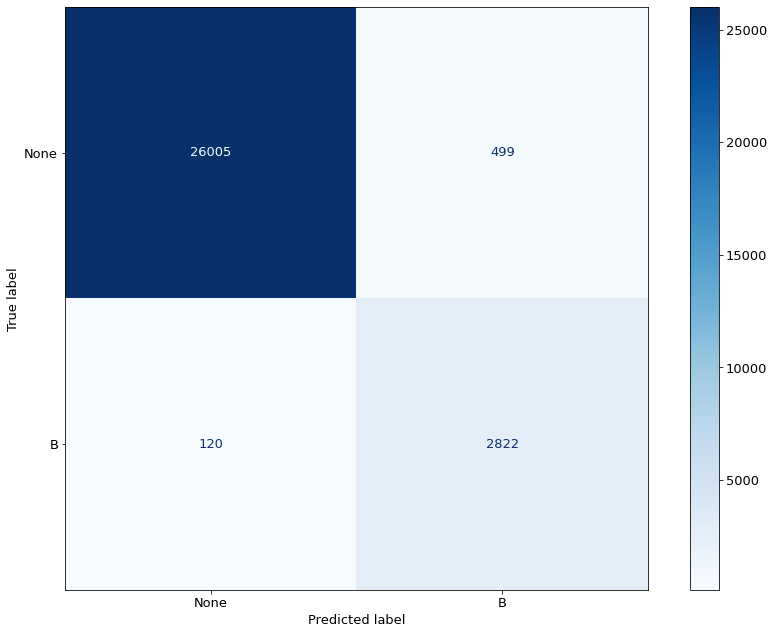

In [ ]:
from sklearn.metrics import mean_squared_error, multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 13})

labels = ["None", 'B']
cm = confusion_matrix(output_real[0], output_preds[0], labels=labels)
for x in range(len(output_real)-1):
  cm += confusion_matrix(output_real[x+1], output_preds[x+1], labels=labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
del cm

In [ ]:
len(output_real)

941

# Test over Text

In [ ]:
def prepare_input(txt):
  inputs = BertTokenizer(txt, return_tensors='pt', padding='max_length', truncation=True, max_length=150).to('cuda')
  return inputs

input_text = ["English is shown to be trans-context-free on the basis of coordinations of the respectively type that involve strictly syntactic cross-serial agreement."]
##input_text = ["The transient analysis of gyro-elastic structured media, composed of periodically placed masses interconnected by elastic rods and attached to gyroscopic spinners, is presented."] 
##input_text = ["The results indicated that thermal curing promoted the early strength of mortars, while decreased the late strength of mortars."] 
##input_text = ["A wide variety of processes are attested in the literature, and we find different forms of clippings in our data, including mixtures of different clippings, homophone respellings, phonetic respellings in-cluding informal oral forms, initialisms (but no acronyms), and mixtures of clipping together with homo-phone and phonetic respellings."] 

#input_text = ["The goal is to accurately predict the running time of applications for task scheduling and job migration."] 
#input_text = ["This paper reports on the development of a cross-domain framework for describing complex design practices."] 
#input_text = ["Studies of inequality in China typically ignore cost of liv-ing differences between areas."] 
#input_text = ["The present study was designed to explore the long-term differences be-tween three mouse models for depression."]
#input_text = ["Finally, regarding professional competencies, teachers appeared to be largely unprepared to conduct language assessments consistent with the LAR demands."] 

##input_text = ["propose a fast and reliable restoration method of virtual resources on OpenStack when physical servers or virtual machines are down."] 
##input_text = ["The results from our simulations reveal that the network assisted adaptation clearly outperforms the purely client-based DASH heuristics in some of the metrics, not all of them, particularly, in situations when the achievable throughput is moderately high or the link quality of the mobile clients does not differ from each other substantially."] 
##input_text = ["For hard rock drilling in coal mine, the drilling efficiency and service life of polycrystalline diamond compact bit are very low."] 
##input_text = ["Capturing changes in foreign reserves and exchange rates through the exchange market pressure, this article investigates whether economic policy uncertainty plays any role in exchange market pressure movements while controlling for the effects of domestic and external factors."] 
##input_text = ["This paper presents design of an self contained actuators unit in wide area damping control of power system in stabilizing system response for both nominal system condition and during actuator faults."] 

##input_text = ["Ultrasound-based brain stimulation techniques may become a powerful new technique to modulate the human brain in a focal and targeted manner."] 
#input_text = ["Recent work pre-training Transformers with self-supervised objectives on large text corpora has shown great success when fine-tuned on downstream NLP tasks including text summarization."]

# Tokenize + pad
inputs = prepare_input(input_text)

#inputs
#print(inputs)

In [ ]:
# Pytorch thing (if we aren't training, do this)
ner_model.eval()

# Get predictions
preds = ner_model(**inputs).cpu().detach().numpy()
preds = np.argmax(preds, axis=-1)[0]
pred_labels = [ID2Entity(x) for x in preds]

# Convert token ids to text
tokens = BertTokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Display result
for token, label in zip(tokens, pred_labels):
  if token == '[SEP]':
    break
  if token == '[CLS]':
    continue
  print('{} -> {}'.format(token, label))

english -> None
is -> None
shown -> None
to -> None
be -> None
trans -> None
- -> None
context -> None
- -> None
free -> None
on -> None
the -> None
basis -> None
of -> None
coordination -> None
##s -> None
of -> None
the -> None
respectively -> None
type -> None
that -> None
involve -> None
strictly -> None
syntactic -> None
cross -> None
- -> None
serial -> None
agreement -> None
. -> None


# Model Save and Load

In [ ]:
print("Our model: \n\n", ner_model, '\n')
print("The state dict keys: \n\n", ner_model.state_dict().keys())

Our model: 

 NerModel(
  (sci_embeddings): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
torch.save(ner_model.state_dict(), 'trained_model_dic.pth')

In [ ]:
# download checkpoint file
files.download('trained_model_dic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls

checkpoint.pth	  model-fold-1.pth  model-fold-4.pth  trained_model_dic.pth
dev.json	  model-fold-2.pth  sample_data       trained_scibert_ner_model
model-fold-0.pth  model-fold-3.pth  test.json	      train.json


Loading the model

In [ ]:
!ls

sample_data  test_500_v2.conll	train_1500_v2.conll  trained_model_dic.pth


In [ ]:
state_dict = torch.load('trained_model_dic.pth')
print(state_dict.keys())

odict_keys(['sci_embeddings.embeddings.position_ids', 'sci_embeddings.embeddings.word_embeddings.weight', 'sci_embeddings.embeddings.position_embeddings.weight', 'sci_embeddings.embeddings.token_type_embeddings.weight', 'sci_embeddings.embeddings.LayerNorm.weight', 'sci_embeddings.embeddings.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.attention.self.query.weight', 'sci_embeddings.encoder.layer.0.attention.self.query.bias', 'sci_embeddings.encoder.layer.0.attention.self.key.weight', 'sci_embeddings.encoder.layer.0.attention.self.key.bias', 'sci_embeddings.encoder.layer.0.attention.self.value.weight', 'sci_embeddings.encoder.layer.0.attention.self.value.bias', 'sci_embeddings.encoder.layer.0.attention.output.dense.weight', 'sci_embeddings.encoder.layer.0.attention.output.dense.bias', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.weight', 'sci_embeddings.encoder.layer.0.attention.output.LayerNorm.bias', 'sci_embeddings.encoder.layer.0.intermediate.dense.weight', 'sci_emb

In [ ]:
ner_model = NerModel(BertEmbModel).to('cuda')
ner_model.load_state_dict(state_dict)

<All keys matched successfully>

# Obtain datasets' weights values (Do not run - fixed values)

In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = train
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = test
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

0:  26504 1:  1496 2:  1446 3:  0 4:  0 5:  0 6:  0


In [ ]:
zero = 0
one=0
two=0 
three=0
four=0
five=0
six=0
local_set = val
for i in range(len(local_set)):
  for j in range(len(local_set[i]['labels'])):
    if local_set[i]['labels'][j] == 0:
      zero += 1
    elif local_set[i]['labels'][j] == 1:
      one += 1
    elif local_set[i]['labels'][j] == 2:
      two += 1
    elif local_set[i]['labels'][j] == 3:
      three += 1
    elif local_set[i]['labels'][j] == 4:
      four += 1
    elif local_set[i]['labels'][j] == 5:
      five += 1
    elif local_set[i]['labels'][j] == 6:
      six += 1
    
print('0: ', zero, '1: ', one, '2: ', two, '3: ', three, '4: ', four, '5: ', five, '6: ', six)

0:  25964 1:  1119 2:  1382 3:  0 4:  0 5:  0 6:  0
